In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("rotten_tomatoes")

Found cached dataset rotten_tomatoes (/home/studio-lab-user/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [7]:
sst_dataset["train"]["text"][0:2]

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .']

In [8]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = sst_dataset["train"]["label"]

In [9]:
sst.label.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [10]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [11]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

16474


In [12]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [13]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=14826)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [14]:
pl.score(sst["text"], sst["label"])

0.8560375146541618

In [15]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1"})

{'fit_time': array([0.24612761, 0.34895539, 0.23380971, 0.24149632, 0.23197341]),
 'score_time': array([0.06849408, 0.0620451 , 0.05894637, 0.06247044, 0.07871151]),
 'test_f1': array([0.73173583, 0.75100633, 0.75622467, 0.73099415, 0.74305556]),
 'test_accuracy': array([0.73094959, 0.74618992, 0.75322392, 0.73036342, 0.73974209])}

In [16]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 0.559 minutes


In [17]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["Rotten_Tomatoes_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [18]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.650645,0.633907,0,Rotten_Tomatoes_Train,2,8530,0.1,33.554051
1,0.664713,0.657074,1,Rotten_Tomatoes_Train,2,8530,0.1,33.554051
2,0.675264,0.644416,2,Rotten_Tomatoes_Train,2,8530,0.1,33.554051
3,0.640680,0.623696,3,Rotten_Tomatoes_Train,2,8530,0.1,33.554051
4,0.664713,0.652913,4,Rotten_Tomatoes_Train,2,8530,0.1,33.554051
5,0.661782,0.658782,0,Rotten_Tomatoes_Train,2,8530,0.2,33.554051
6,0.672333,0.675942,1,Rotten_Tomatoes_Train,2,8530,0.2,33.554051
7,0.690504,0.690867,2,Rotten_Tomatoes_Train,2,8530,0.2,33.554051
8,0.690504,0.693380,3,Rotten_Tomatoes_Train,2,8530,0.2,33.554051
9,0.676436,0.678696,4,Rotten_Tomatoes_Train,2,8530,0.2,33.554051


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

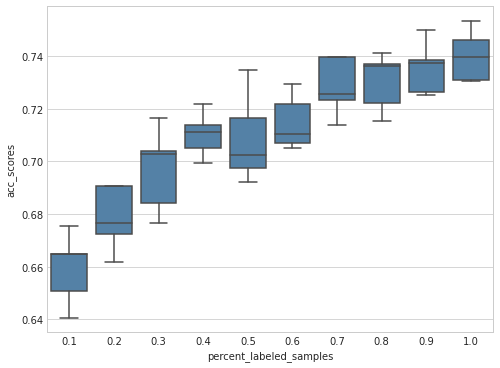

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [20]:
dataset_report.to_csv("rotten_tomatoes.csv", index_label=False)

In [21]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()